**Train a model with real estate data using XGBoost algorithm**

## Import Libraries and Load Dataset

In [1]:
# Install necessary libraries
# !pip install xgboost
# !pip install sagemaker


# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance


%matplotlib inline

## Modeling

In [2]:
df_final=pd.read_csv('data/final_dataset.csv')

In [3]:
# Define X and y
target_feature = 'actual_worth'
X = df_final.drop([target_feature], axis=1)
y = df_final[target_feature]

### Train the model

In [4]:
# Transform data of object type to categories for XGBoost Regressor
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols]=X[categorical_cols].astype("category")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161681 entries, 0 to 161680
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   trans_group_en        161681 non-null  category
 1   procedure_name_en     161681 non-null  category
 2   property_sub_type_en  161681 non-null  category
 3   property_usage_en     161681 non-null  category
 4   reg_type_en           161681 non-null  category
 5   area_name_en          161681 non-null  category
 6   master_project_en     142937 non-null  category
 7   nearest_landmark_en   143790 non-null  category
 8   nearest_metro_en      125540 non-null  category
 9   nearest_mall_en       125453 non-null  category
 10  rooms_en              161681 non-null  category
 11  has_parking           161681 non-null  int64   
 12  procedure_area        161681 non-null  float64 
dtypes: category(11), float64(1), int64(1)
memory usage: 4.2 MB


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

In [5]:
# Define XGBoost Regressor model
model = XGBRegressor(objective='reg:squarederror', 
                     learning_rate=0.1, 
                     max_depth=30, 
                     n_estimators=100, 
                     verbosity = 2,
                     eval_metric='rmse',
                     early_stopping_rounds=10,
                     enable_categorical=True
                     )

model.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_val,y_val)])

# Evaluate the model
score = model.score(X_test, y_test)
print("Model Score:", score)

[0]	validation_0-rmse:892049.37724	validation_1-rmse:893668.45024
[1]	validation_0-rmse:818678.08674	validation_1-rmse:824423.09485
[2]	validation_0-rmse:753395.50568	validation_1-rmse:763472.80155
[3]	validation_0-rmse:695399.69954	validation_1-rmse:710268.43351
[4]	validation_0-rmse:643933.44560	validation_1-rmse:663552.49084
[5]	validation_0-rmse:598444.54019	validation_1-rmse:622879.75325
[6]	validation_0-rmse:558279.77335	validation_1-rmse:588017.15434
[7]	validation_0-rmse:522970.25594	validation_1-rmse:558012.01109
[8]	validation_0-rmse:491987.23917	validation_1-rmse:532427.82130
[9]	validation_0-rmse:464795.39775	validation_1-rmse:510507.86661
[10]	validation_0-rmse:441130.12220	validation_1-rmse:492165.25951
[11]	validation_0-rmse:420427.40739	validation_1-rmse:476747.40735
[12]	validation_0-rmse:402440.52956	validation_1-rmse:463946.26928
[13]	validation_0-rmse:386856.42178	validation_1-rmse:453319.69416
[14]	validation_0-rmse:373381.25304	validation_1-rmse:444745.25611
[15]	

In [6]:
eval_result = model.evals_result()

In [7]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

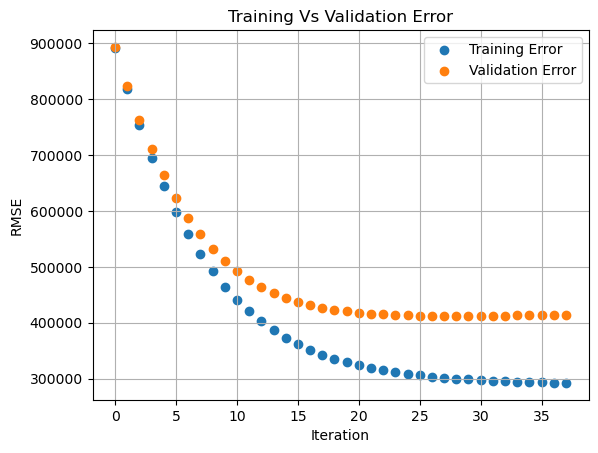

In [8]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

### Hyperparameter tuning

Hyperparameter tuning with **GridSearchCV**

In [ ]:
# Define the hyperparameter grid
# Total model combinations = 3*3*2 = 12
# kfold = 5
# Total interations = 12*5 = 60
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # Add learning_rate to the param_grid
    'max_depth': [10, 20, 30],
    'subsample': [0.7, 1]
}

# Create the XGBoost model object with default parameters
xgb_model = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=5, 
    enable_categorical=True
)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)]) 

In [11]:
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1}
# Best score:  -394905.74256491277

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1}
Best score:  -394905.74256491277


Hyperparameter tuning with **RandomizedSearchCV**

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
# Total model combinations = 3*3*2 = 12
# kfold = 5
# Total interations = 12*5 = 60
# param_grid = {
#     'model__learning_rate': [0.1, 0.01, 0.001],  # Add learning_rate to the param_grid
#     'model__max_depth': [3, 5, 7],
#     'model__subsample': [0.7, 1]
# }

param_dist = {
    'max_depth': stats.randint(3, 25),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
    }

# Create the XGBoost model object with default parameters
xgb_model = XGBRegressor(
    colsample_bytree=0.5, 
    early_stopping_rounds=5, 
    enable_categorical=True
    )

# Create the RandomizedSearchCV object
randomized_search = RandomizedSearchCV(
    xgb_model, 
    param_dist, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

# Fit the RandomizedSearchCV object to the training data
randomized_search.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)])

In [14]:
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", randomized_search.best_params_)
print("Best score: ", randomized_search.best_score_)

# Best set of hyperparameters:  {'learning_rate': 0.0701354204238183, 'max_depth': 16, 'n_estimators': 143, 'subsample': 0.9060458311196495}
# Best score:  -392647.60055029264


Best set of hyperparameters:  {'learning_rate': 0.0701354204238183, 'max_depth': 16, 'n_estimators': 143, 'subsample': 0.9060458311196495}
Best score:  -392647.60055029264


### Final model with tuned hyperparameters

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

# Define XGBoost Regressor model
model = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    learning_rate=0.0701354204238183, 
    max_depth=16, 
    subsample=0.9060458311196495, 
    n_estimators=143
    )

# Fit the pipeline on the training data
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print("Model Score:", score)

Model Score: 0.8206876107241533


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

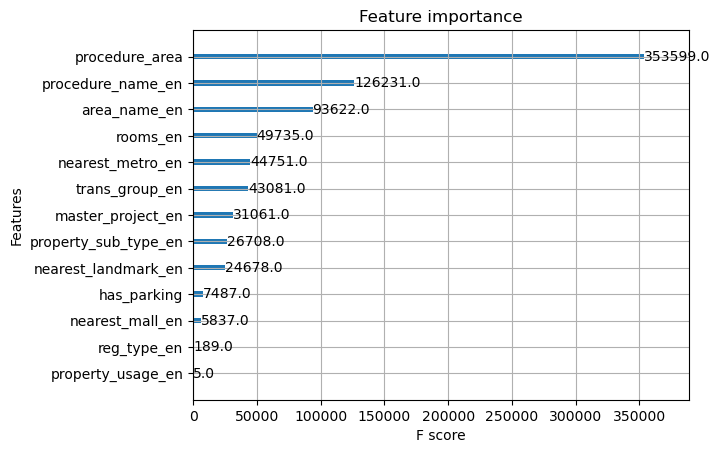

In [28]:
plot_importance(model)

### Make predictions and evaluate the model

In [42]:
y_predict = model.predict(X_test)

In [63]:
df = pd.DataFrame({'y_test': y_test.reset_index(drop=True), 'y_pred': y_predict.round(2)})
print(df.head())

      y_test       y_pred
0  2700000.0  1727426.500
1  1672000.0  1842497.500
2  1100000.0  1367374.125
3  1158575.0  1455217.250
4   240000.0   324356.000


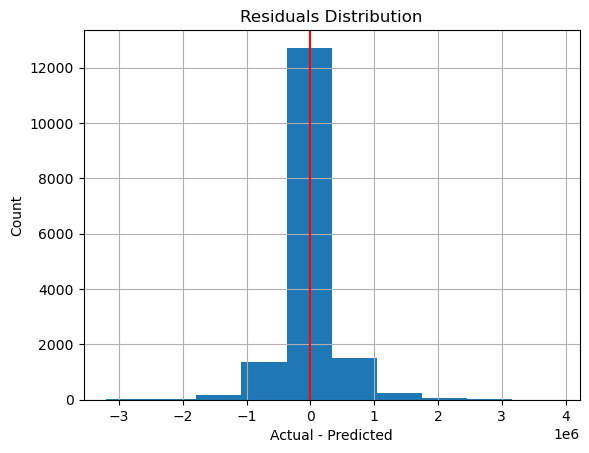

In [69]:
# Over prediction and Under Prediction needs to be balanced
# Test Data Residuals
residuals = (df['y_test'] - df['y_pred'])

plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [70]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.47
 Over  Estimation: 0.53


In [18]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
# coefficient of determination - how much variance can be explained by the given features
r2 = r2_score(y_test, y_predict)
# adjusted R-squared - adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 398835.08 
MSE = 159069421389.19092 
MAE = 241189.69304915573 
R2 = 0.828547111120663 
Adjusted R2 = 0.8284091336813024
